https://www.kaggle.com/veb101/facial-expression-recognition-using-pytorch/notebook

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import seaborn as sns
%matplotlib inline
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import sklearn as skl
from tqdm import tqdm

from torchsummary import summary

from PIL import Image
import torch.nn.functional as F
import torch.nn as nn

import torchvision
import torchvision.transforms as T
from torchvision.utils import make_grid

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
pd.set_option('display.max_columns', 20)

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import os, sys
os.chdir("/gdrive/My Drive/Colab Notebooks/PyTorch")
path='/gdrive/My Drive/Colab Notebooks/PyTorch'

In [ ]:
USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cuda


# dataset 불러오기

In [ ]:
dataset = pd.read_csv(path+'/fer20131.csv')
dataset

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [ ]:
dataset.Usage.value_counts() # 훈련, 검증용 데이터 수 확인 PublicTest가 테스트용

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

## Pixel column의 데이터를 pixel화 하기
48*48짜리로 바꿔야 함

In [ ]:
trn_index=dataset.Usage=='Training'
vld_index=dataset.Usage=='PrivateTest'
tst_index=dataset.Usage=='PublicTest'


In [ ]:
x = []

for pix in dataset.pixels:
    values = [int(i) for i in pix.split()]
    x.append(values)

x = np.array(x).reshape(-1,1,48,48)
x.shape


(35887, 1, 48, 48)

In [ ]:
x_scaled=x/255
x_scaled

array([[[[0.2745098 , 0.31372549, 0.32156863, ..., 0.20392157,
          0.16862745, 0.16078431],
         [0.25490196, 0.23921569, 0.22745098, ..., 0.21960784,
          0.20392157, 0.17254902],
         [0.19607843, 0.16862745, 0.21176471, ..., 0.19215686,
          0.21960784, 0.18431373],
         ...,
         [0.35686275, 0.25490196, 0.16470588, ..., 0.28235294,
          0.21960784, 0.16862745],
         [0.30196078, 0.32156863, 0.30980392, ..., 0.41176471,
          0.2745098 , 0.18039216],
         [0.30196078, 0.28235294, 0.32941176, ..., 0.41568627,
          0.42745098, 0.32156863]]],


       [[[0.59215686, 0.58823529, 0.57647059, ..., 0.50588235,
          0.54901961, 0.47058824],
         [0.59215686, 0.58431373, 0.58431373, ..., 0.47843137,
          0.55294118, 0.5372549 ],
         [0.59215686, 0.59215686, 0.61176471, ..., 0.42745098,
          0.48235294, 0.57254902],
         ...,
         [0.7372549 , 0.7372549 , 0.4745098 , ..., 0.7254902 ,
          0.7254902 , 0

In [ ]:
x_train=x_scaled[trn_index]
x_valid=x_scaled[vld_index]
x_test=x_scaled[tst_index]

x_train.shape, x_valid.shape, x_test.shape

((28709, 1, 48, 48), (3589, 1, 48, 48), (3589, 1, 48, 48))

In [ ]:
y=np.array(dataset.emotion)
y_train=y[trn_index]
y_valid=y[vld_index]
y_test=y[tst_index]

y_train.shape, y_valid.shape, y_test.shape

((28709,), (3589,), (3589,))

In [ ]:
emotions = {
    0: 'Angry', 
    1: 'Disgust', 
    2: 'Fear', 
    3: 'Happy', 
    4: 'Sad', 
    5: 'Surprise', 
    6: 'Neutral'
}

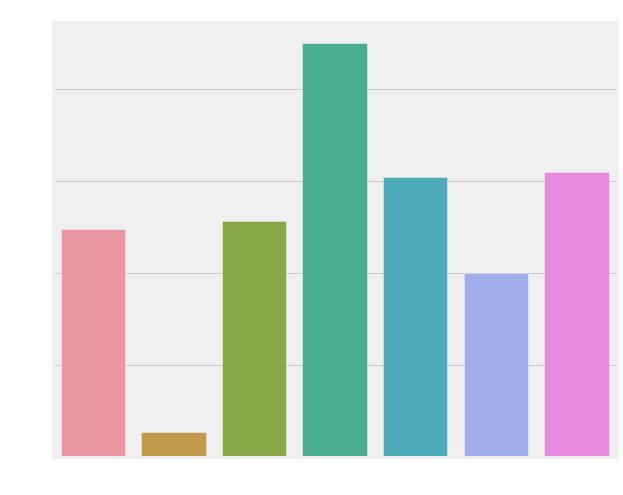

In [ ]:
plt.figure(figsize=(9, 8))
sns.countplot(x=dataset.emotion)
_ = plt.title('Emotion Distribution',fontsize=12,color='white')
_ = plt.xticks(ticks=range(0, 7), labels=[emotions[i] for i in range(0, 7)],color='white' )
_ = plt.xlabel('emotion',color='white')
_ = plt.ylabel('count',color='white')
_ = plt.yticks(color='white')

## Customized Dataset 만들기

In [ ]:
emotions[6]

'Neutral'

In [ ]:
from torch.utils.data import Dataset as Dataset

In [ ]:
class Trainset(Dataset): 
  def __init__(self,transform=None):
    self.x_data = torch.from_numpy(x_train).double()
    self.y_data = torch.from_numpy(y_train)
    self.transform=transform
  # 총 데이터의 개수를 리턴
  def __len__(self): 
    return len(self.x_data)

  # 인덱스를 입력받아 그에 맵핑되는 입출력 데이터를 파이토치의 Tensor 형태로 리턴
  def __getitem__(self, idx): 
    x = self.x_data[idx]
    y = self.y_data[idx]
    if self.transform:
      x = self.transform(x)
    return x, y

In [ ]:
class Validset(torch.utils.data.Dataset): 
  def __init__(self,transform=None):
    self.x_data = torch.from_numpy(x_valid).double()
    self.y_data = torch.from_numpy(y_valid)
    self.transform=transform
  # 총 데이터의 개수를 리턴
  def __len__(self): 
    return len(self.x_data)

  # 인덱스를 입력받아 그에 맵핑되는 입출력 데이터를 파이토치의 Tensor 형태로 리턴
  def __getitem__(self, idx): 
    x = self.x_data[idx]
    y = self.y_data[idx]
    if self.transform:
      x = self.transform(x)
    return x, y

In [ ]:
transform=transforms.Compose(
    [#transforms.ToTensor(),
     transforms.RandomHorizontalFlip(p=0.5)#])#,
     #transforms.Resize()
     ,transforms.Normalize((0.5),(0.5))])

In [ ]:
trainset=Trainset(transform=transform)
validset=Validset(transform=transform)
dataset_sizes = {'train':len(trainset),'valid':len(validset)}

In [ ]:
trainloader=torch.utils.data.DataLoader(trainset,batch_size=16,shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=16,shuffle=True)

In [ ]:
dataloader={'train':trainloader,'valid':validloader}

## img 확인

torch.Size([16, 1, 48, 48])
tensor([2, 1, 4, 0, 2, 2, 6, 5, 2, 1, 2, 4, 6, 6, 0, 6])
 Fear Disgust   Sad Angry  Fear  Fear Neutral Surprise  Fear Disgust  Fear   Sad Neutral Neutral Angry Neutral


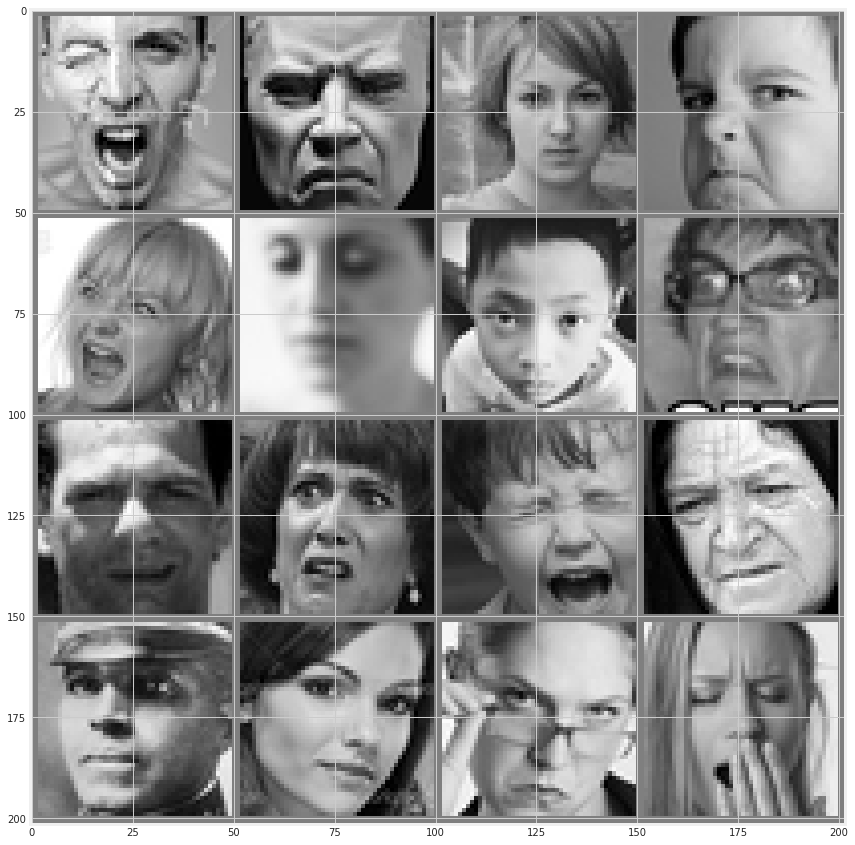

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(15,15))
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    #첫번째 원소를 두번째, 두번째 원소를 마지막, 마지막 원소를 첫번째 위치로


# get some random training images
dataiter = iter(trainloader) #iter는 원하는 값이 나올 때 까지 특정대상을 계속 돌림
images, labels = dataiter.next() #iter 다음에는 next로 부름
print(images.shape) # 16개 짜리 미니배치, 이미지 사이즈는 (1,48,48)
print(labels) # y가 숫자로 되어있고 그 숫자를 부르는 것임. 그래서label[j]가 필요

# show images
imshow(torchvision.utils.make_grid(images,nrow=4))
#Make a grid of images.

#Args:
#    tensor (Tensor or list): 4D mini-batch Tensor of shape (B x C x H x W)  
#        or a list of images all of the same size.

print(' '.join('%5s' % emotions[int(labels[j])] for j in range(16)))

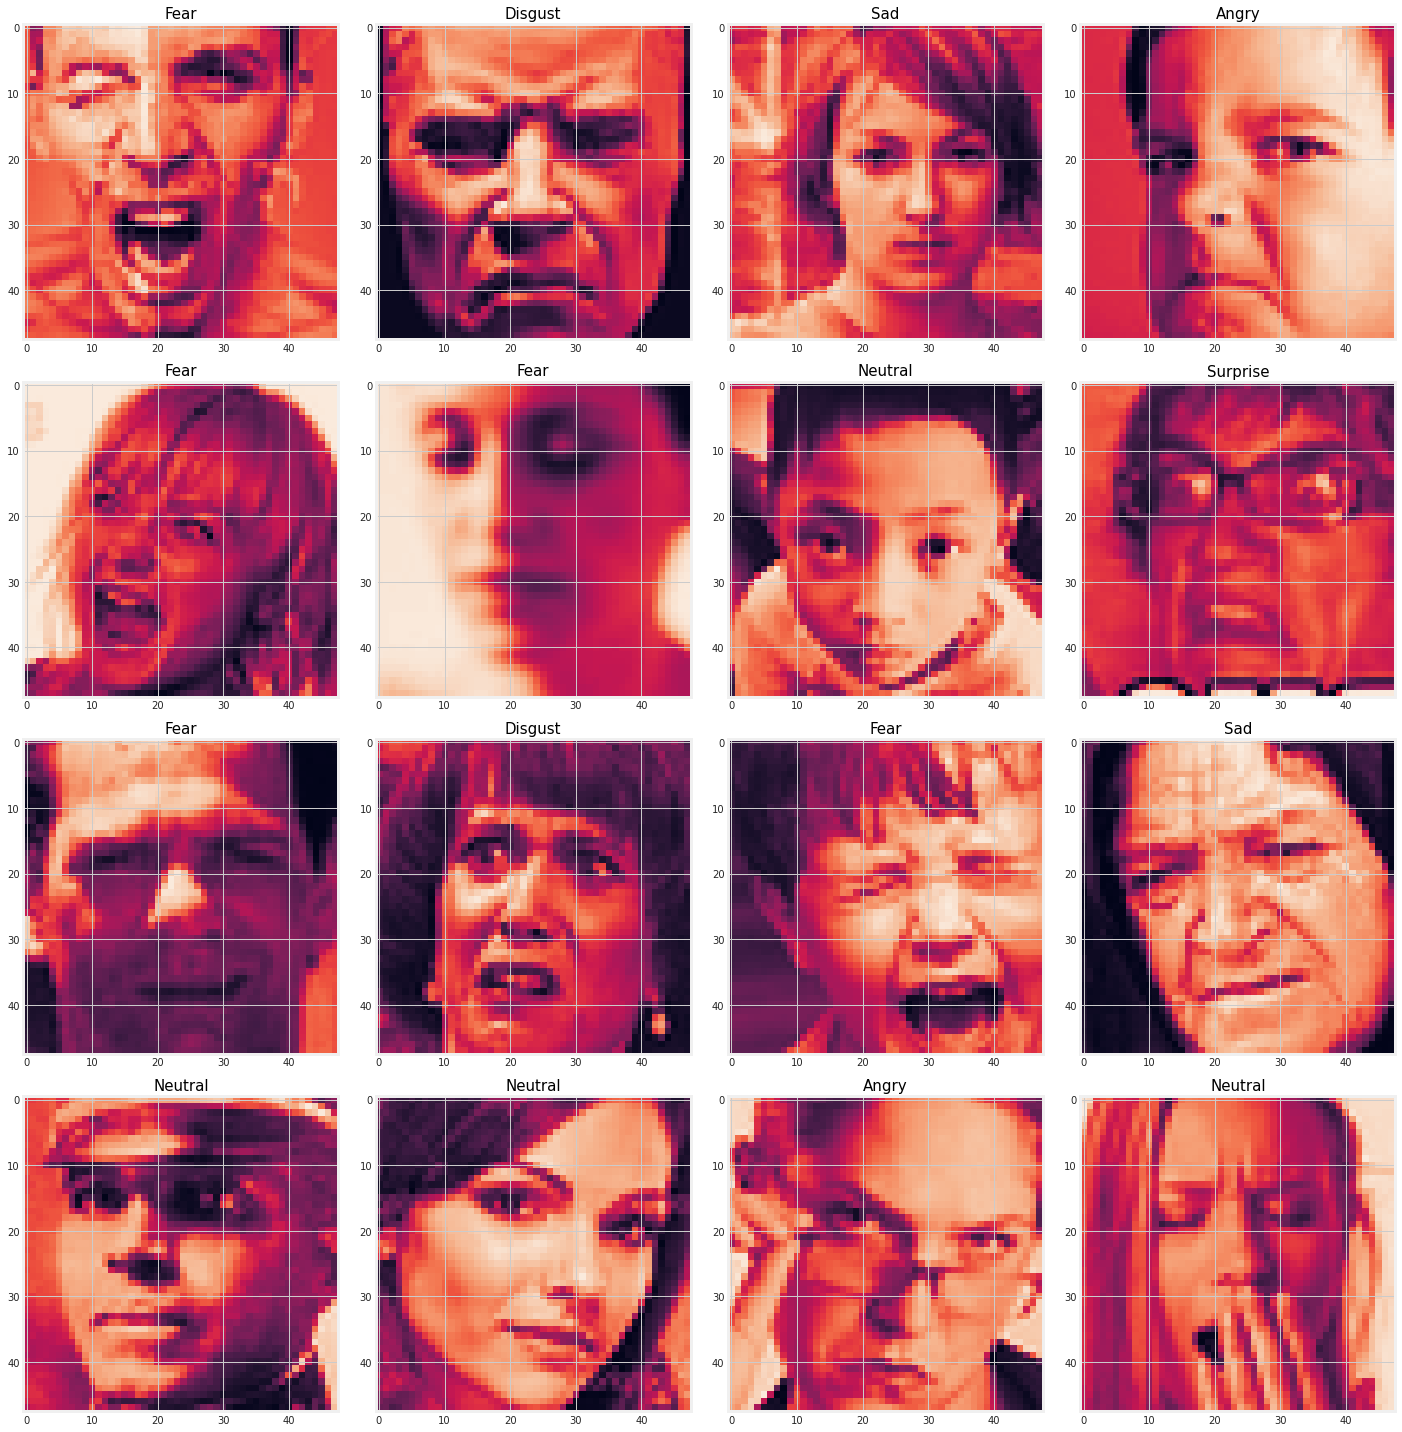

In [ ]:
axes=[]
fig=plt.figure(figsize=(20,20))
rows=cols=4
for a in range(rows*cols):
    img = images[a].view(48,48)
    axes.append( fig.add_subplot(rows, cols, a+1) )
    
    axes[-1].set_title(emotions[int(labels[a])],fontsize=15, color='black')  
    plt.imshow(img)
fig.tight_layout()    
plt.show()

In [ ]:
dataloader['valid']

# Modeling

## Model Training 함수

In [ ]:
from torch.optim import lr_scheduler
import copy
import time

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device,dtype=torch.double)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs).to(device=device, dtype=torch.double)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## 1) 일반 CNN

In [ ]:
from collections import OrderedDict
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

      #(16,1,48,48)

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
            
        #(16,1,24,24)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        #(16,1,12,12)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128,128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        

        self.fc1=torch.nn.Sequential(OrderedDict([
            ('Linear',torch.nn.Linear(6* 6 * 128, 128, bias=True)),
            ('Dropout',torch.nn.Dropout(0.5,inplace=False)),
            ('ReLU',torch.nn.ReLU())]))
        
        
        self.fc2=torch.nn.Sequential(OrderedDict([
            ('Linear',torch.nn.Linear(128, 128, bias=True)),
            ('Dropout',torch.nn.Dropout(0.5,inplace=False)),
            ('ReLU',torch.nn.ReLU())]))
        
        self.result_layer=torch.nn.Linear(128, 7, bias=True)
         
        # 전결합층 한정으로 가중치 초기화
        torch.nn.init.xavier_normal(self.result_layer.weight)
        torch.nn.init.xavier_normal(self.fc1.Linear.weight)
        torch.nn.init.xavier_normal(self.fc2.Linear.weight)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(-1,6*6*128)    # 전결합층을 위해서 Flatten
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.result_layer(out)

        return out



In [ ]:
model_ft = CNN().to(device,dtype=torch.double)
criterion = nn.CrossEntropyLoss().to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


In [ ]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 1/25
----------
train Loss: 1.8114 Acc: 0.2506
valid Loss: 1.7946 Acc: 0.2477

Epoch 2/25
----------
train Loss: 1.7911 Acc: 0.2543
valid Loss: 1.7712 Acc: 0.2536

Epoch 3/25
----------
train Loss: 1.7611 Acc: 0.2757
valid Loss: 1.7054 Acc: 0.3123

Epoch 4/25
----------
train Loss: 1.6971 Acc: 0.3157
valid Loss: 1.6450 Acc: 0.3500

Epoch 5/25
----------
train Loss: 1.6287 Acc: 0.3568
valid Loss: 1.5318 Acc: 0.4129

Epoch 6/25
----------
train Loss: 1.5729 Acc: 0.3851
valid Loss: 1.4999 Acc: 0.4157

Epoch 7/25
----------
train Loss: 1.5226 Acc: 0.4086
valid Loss: 1.4672 Acc: 0.4427

Epoch 8/25
----------
train Loss: 1.5107 Acc: 0.4131
valid Loss: 1.4562 Acc: 0.4439

Epoch 9/25
----------
train Loss: 1.5000 Acc: 0.4166
valid Loss: 1.4475 Acc: 0.4503

Epoch 10/25
----------
train Loss: 1.4911 Acc: 0.4218
valid Loss: 1.4395 Acc: 0.4533

Epoch 11/25
----------
train Loss: 1.4856 Acc: 0.4274
valid Loss: 1.4334 Acc: 0.4503

Epoch 12/25
----------
train Loss: 1.4822 Acc: 0.4282
valid Los

## 모델저장

In [ ]:
PATH='/gdrive/My Drive/Colab Notebooks/PyTorch/fer_model1.pt'

In [ ]:
torch.save({
            'model_state_dict': model_ft.state_dict(),
            'optimizer_state_dict': optimizer_ft.state_dict(),
             }, PATH)

In [ ]:
# CNN 모델 정의
model2 = CNN().to(device,dtype=torch.double)


criterion = torch.nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


## 모델불러오기 및 학습 진행

In [ ]:
optimizer2= torch.optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
PATH='/gdrive/My Drive/Colab Notebooks/PyTorch/fer_model1.pt'
checkpoint = torch.load(PATH)
model2.load_state_dict(checkpoint['model_state_dict'])
optimizer2.load_state_dict(checkpoint['optimizer_state_dict'])

model2.train()
criterion = torch.nn.CrossEntropyLoss().to(device)

In [ ]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer2, step_size=7, gamma=0.1)
model_ft = train_model(model2, criterion, optimizer2, exp_lr_scheduler,
                       num_epochs=25)

Epoch 1/25
----------
train Loss: 1.8184 Acc: 0.2510
valid Loss: 1.8171 Acc: 0.2449

Epoch 2/25
----------
train Loss: 1.8173 Acc: 0.2508
valid Loss: 1.8171 Acc: 0.2449

Epoch 3/25
----------
train Loss: 1.8182 Acc: 0.2512
valid Loss: 1.8171 Acc: 0.2449

Epoch 4/25
----------
train Loss: 1.8178 Acc: 0.2511
valid Loss: 1.8171 Acc: 0.2449

Epoch 5/25
----------
train Loss: 1.8172 Acc: 0.2510
valid Loss: 1.8170 Acc: 0.2449

Epoch 6/25
----------
train Loss: 1.8170 Acc: 0.2510
valid Loss: 1.8170 Acc: 0.2449

Epoch 7/25
----------
train Loss: 1.8184 Acc: 0.2509
valid Loss: 1.8170 Acc: 0.2449

Epoch 8/25
----------
train Loss: 1.8177 Acc: 0.2509
valid Loss: 1.8170 Acc: 0.2449

Epoch 9/25
----------
train Loss: 1.8177 Acc: 0.2511
valid Loss: 1.8170 Acc: 0.2449

Epoch 10/25
----------
train Loss: 1.8170 Acc: 0.2510
valid Loss: 1.8170 Acc: 0.2449

Epoch 11/25
----------
train Loss: 1.8173 Acc: 0.2513
valid Loss: 1.8170 Acc: 0.2449

Epoch 12/25
----------
train Loss: 1.8181 Acc: 0.2509
valid Los

## 보류 ** Fine Tuning : VGG11



In [ ]:
model_ft = torchvision.models.vgg11(pretrained=True)
num_ftrs = 256
model_ft.state_dict


<bound method Module.state_dict of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, paddin

In [ ]:
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 1/25
----------


RuntimeError: ignored